# Visualisations of the Tracked Regional European Events (OSTIA Observations) using `plotX`
cf. Plots when exchange for Basic Tracking (i.e. `extreme_events_basic_regional.zarr`)

In [1]:
from getpass import getuser
from pathlib import Path

import dask
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr

import marEx
import marEx.helper as hpc

In [2]:
# Directories
scratch_dir = Path("/scratch") / getuser()[0] / getuser()  # Lustre Scratch Directory

file_name = scratch_dir / "mhws" / "extreme_events_merged_regional_shifting.zarr"
plot_dir = scratch_dir / "mhws" / "plots"

In [3]:
# Start Dask Cluster
client = hpc.start_local_cluster(
    n_workers=32, threads_per_worker=1, scratch_dir=scratch_dir / "clients"
)  # Specify temporary scratch directory for dask to use

Hostname: l10587
Forward Port: l10587:8787
Dashboard Link: localhost:8787/status


In [4]:
# Import Tracked Extremes DataSet
extreme_events_ds = xr.open_zarr(str(file_name), chunks={})
extreme_events_ds

<xarray.Dataset> Size: 32GB
Dimensions:       (ID: 1877, time: 9282, lat: 700, lon: 1200, component: 2,
                   sibling_ID: 8)
Coordinates:
  * ID            (ID) int32 8kB 1 2 3 4 5 6 7 ... 1872 1873 1874 1875 1876 1877
  * lat           (lat) float32 3kB 30.02 30.08 30.12 ... 64.88 64.93 64.97
  * lon           (lon) float32 5kB -19.98 -19.92 -19.88 ... 39.88 39.92 39.97
  * time          (time) datetime64[ns] 74kB 1997-01-01T12:00:00 ... 2022-05-...
Dimensions without coordinates: component, sibling_ID
Data variables:
    ID_field      (time, lat, lon) int32 31GB dask.array<chunksize=(1, 700, 1200), meta=np.ndarray>
    area          (time, ID) float32 70MB dask.array<chunksize=(1, 1877), meta=np.ndarray>
    centroid      (component, time, ID) float64 279MB dask.array<chunksize=(1, 1, 1877), meta=np.ndarray>
    global_ID     (time, ID) int32 70MB dask.array<chunksize=(1, 1877), meta=np.ndarray>
    merge_ledger  (time, ID, sibling_ID) int32 558MB dask.array<chunksize=(1, 1877, 8), meta=np.ndarray>
    presence      (time, ID) bool 17MB dask.array<chunksize=(1, 1877), meta=np.ndarray>
    time_end      (ID) datetime64[ns] 15kB dask.array<chunksize=(1877,), meta=np.ndarray>
    time_start    (ID) datetime64[ns] 15kB dask.array<chunksize=(1877,), meta=np.ndarray>
Attributes: (12/14)
    N_events_final:              1877
    N_objects_filtered:          16339
    N_objects_prefiltered:       32679
    R_fill:                      16
    T_fill:                      4
    accepted_area_fraction:      0.9381797362068869
    ...                          ...
    area_threshold (cells):      2569.0
    multi_parent_merges:         943
    nn_partitioning:             1
    overlap_threshold:           0.5
    preprocessed_area_fraction:  0.7528422832413386
    total_merges:                3425

In [5]:
# Extract the Events ID Field
ID_field = extreme_events_ds.ID_field
ID_field

<xarray.DataArray 'ID_field' (time: 9282, lat: 700, lon: 1200)> Size: 31GB
dask.array<open_dataset-ID_field, shape=(9282, 700, 1200), dtype=int32, chunksize=(1, 700, 1200), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 30.02 30.08 30.12 30.17 ... 64.88 64.93 64.97
  * lon      (lon) float32 5kB -19.98 -19.92 -19.88 -19.83 ... 39.88 39.92 39.97
  * time     (time) datetime64[ns] 74kB 1997-01-01T12:00:00 ... 2022-05-31T12...

## Make a Movie using `plotX.animate`
N.B.: Making `dask`-powered movies using `animate()` cannot be threaded !

In [ ]:
# Choose a subset of the ID field
ID_field_subset = ID_field.sel(time=slice("2020-01-01", "2022-05-31"))

# Setup Plotting Configuration & Animate
config = marEx.PlotConfig(plot_IDs=True, projection=ccrs.PlateCarree())
ID_field_subset.plotX.animate(config, plot_dir=plot_dir, file_name="movie_ID_field_regional", )

In [7]:
%%HTML
<video width="640" height="480" controls>
    <source src="../../media/movie_ID_field_regional.mp4" type="video/mp4">
    Your browser does not support the video tag.
</video>

cf. "Basic" Tracking, i.e. the current standard method in the literature, involving _No_ temporal gap filling, _No_ merging/splitting and _No_ independent event tracking.

In [ ]:
# Choose a subset of the "Basic" ID field
ID_field_basic_subset = xr.open_zarr(str(file_name).replace("merged", "basic"), chunks={}).ID_field.sel(
    time=slice("2020-01-01", "2022-05-31")
)

# Setup Plotting Configuration & Animate
config = marEx.PlotConfig(plot_IDs=True, projection=ccrs.PlateCarree())
ID_field_basic_subset.plotX.animate(config, plot_dir=plot_dir, file_name="movie_ID_field_basic_regional")

In [9]:
%%HTML
<video width="640" height="480" controls>
    <source src="../../media/movie_ID_field_basic_regional.mp4" type="video/mp4">
    Your browser does not support the video tag.
</video>

## Plot Consecutive Days of Extreme Events

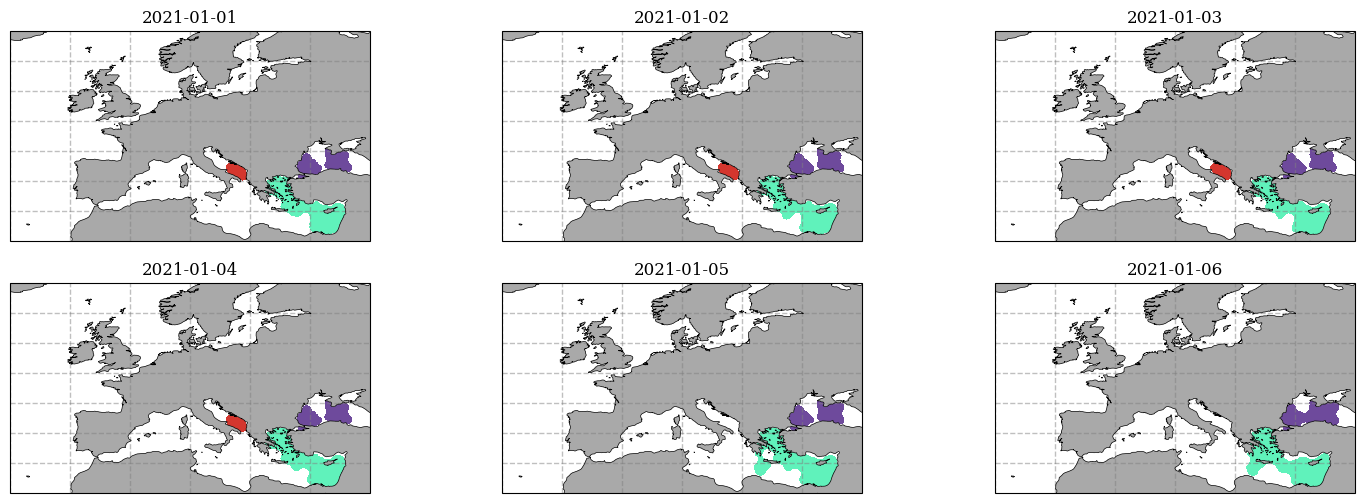

In [10]:
# Choose a subset of the ID field
ID_field_subset = ID_field.sel(time=slice("2021-01-01", "2021-01-06"))

# Setup Plotting Configuration
config = marEx.PlotConfig(plot_IDs=True, projection=ccrs.PlateCarree())
fig, ax = ID_field_subset.plotX.multi_plot(config, col="time", col_wrap=3);

## Plot Regional Extreme Event Frequency

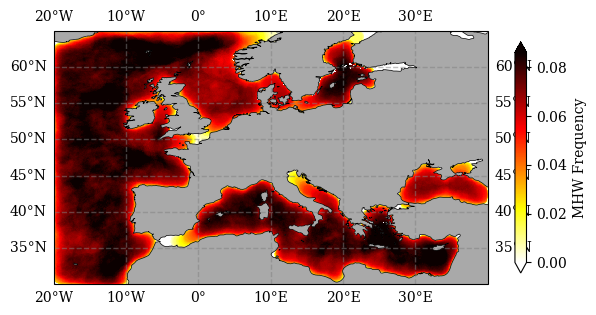

In [11]:
# Calculate the frequency of Event Occurrence
event_frequency = (ID_field > 0).mean("time")

# Setup Plotting Configuration
config = marEx.PlotConfig(var_units="MHW Frequency", cmap="hot_r", cperc=[0, 96], grid_labels=True, projection=ccrs.PlateCarree())
fig, ax, im = event_frequency.plotX.single_plot(config)

## Plot Seasonal Extreme Event Frequency

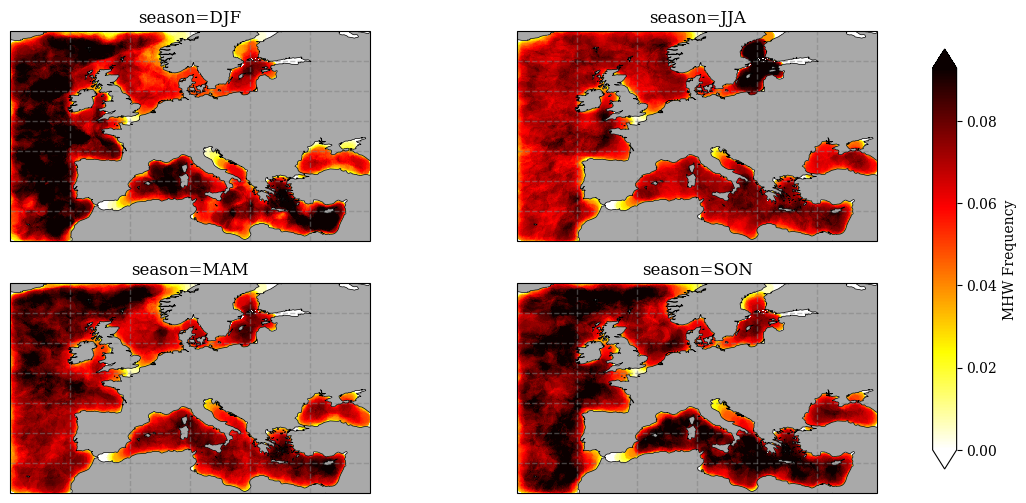

In [12]:
# Calculate the frequency of Event Occurrence per season
seasonal_frequency = (ID_field > 0).groupby("time.season").mean(dim="time")

# Setup Plotting Configuration
config = marEx.PlotConfig(var_units="MHW Frequency", cmap="hot_r", cperc=[0, 96], grid_labels=True, projection=ccrs.PlateCarree())
fig, ax = seasonal_frequency.plotX.multi_plot(config, col="season", col_wrap=2);

## Find & Plot a Few of the Longest Regional Events

In [13]:
events_duration = extreme_events_ds.time_end - extreme_events_ds.time_start
longest_events = events_duration.sortby(events_duration, ascending=False).ID

for ID in longest_events[:10].values:
    print(
        f"ID: {ID:<6}   Start Day: {extreme_events_ds.time_start.sel(ID=ID).dt.strftime('%Y-%m-%d').values}  -->  Duration: {events_duration.sel(ID=ID).dt.days.values:<4} days"
    )

ID: 67       Start Day: 1997-09-24  -->  Duration: 180  days
ID: 73       Start Day: 1997-10-20  -->  Duration: 171  days
ID: 934      Start Day: 2007-10-08  -->  Duration: 164  days
ID: 532      Start Day: 2002-11-23  -->  Duration: 164  days
ID: 1860     Start Day: 2021-12-18  -->  Duration: 157  days
ID: 535      Start Day: 2002-11-27  -->  Duration: 155  days
ID: 76       Start Day: 1997-11-08  -->  Duration: 155  days
ID: 152      Start Day: 1998-10-07  -->  Duration: 152  days
ID: 849      Start Day: 2006-09-17  -->  Duration: 144  days
ID: 445      Start Day: 2001-11-21  -->  Duration: 135  days


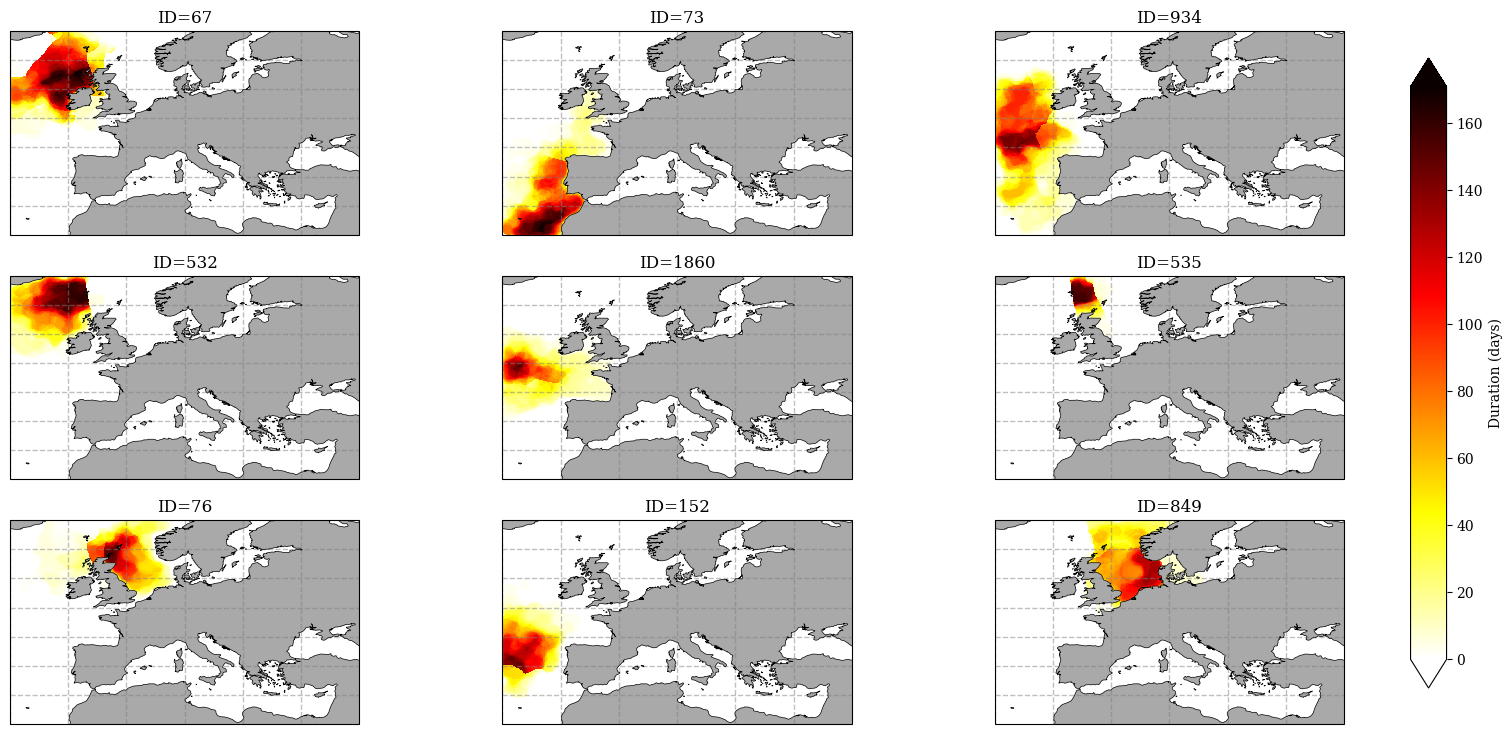

In [14]:
# Calculate the local duration of the longest events
long_events = ID_field == (longest_events[:9]).chunk({"ID": 1})
long_events_local_duration = (long_events > 0).sum("time")

# Setup Plotting Configuration
config = marEx.PlotConfig(var_units="Duration (days)", cmap="hot_r", cperc=[0, 100], projection=ccrs.PlateCarree())
fig, ax = long_events_local_duration.plotX.multi_plot(config, col="ID", col_wrap=3);

## ID Maximum and Mean Event Area
Units for `extreme_events_ds.area` when using gridded data is 'cells'. Here we must convert to km².

In [15]:
# Calculate grid areas
R_earth = 6371.0  # km
resolution = 0.05 # deg

lat_r, lon_r, dlat, dlon = (
    np.radians(extreme_events_ds.lat),
    np.radians(extreme_events_ds.lon),
    np.radians(resolution),
    np.radians(resolution),
)
grid_area = (R_earth**2 * np.abs(np.sin(lat_r + dlat / 2) - np.sin(lat_r - dlat / 2)) * dlon).astype(np.float32)

In [16]:
def compute_areas_by_id(id_field, grid_area, unique_ids, presence):
    """Compute area for each ID using efficient indexing"""
    # Broadcast grid_area to match id_field shape
    grid_broadcast = np.broadcast_to(grid_area[:, np.newaxis], id_field.shape)
    areas = np.zeros(len(unique_ids), dtype=np.float32)

    # Vectorised accumulation
    flat_ids = id_field.ravel()
    flat_grid = grid_broadcast.ravel()

    for idx, id_val in enumerate(unique_ids):
        if presence[idx]:  # Only process non-zero IDs
            areas[idx] = flat_grid[flat_ids == id_val].sum()
        else:
            areas[idx] = 0.0

    return areas


areas = xr.apply_ufunc(
    compute_areas_by_id,
    extreme_events_ds.ID_field,
    grid_area,
    extreme_events_ds.ID,
    extreme_events_ds.presence,
    input_core_dims=[["lat", "lon"], ["lat"], ["ID"], ["ID"]],
    output_core_dims=[["ID"]],
    dask="parallelized",
    vectorize=True,
    output_dtypes=[np.float32],
)

areas = areas.where(extreme_events_ds.presence, np.nan).compute()

In [17]:
areas_max = areas.max().compute()
print(f"Maximum object area: {areas_max.values:.0f} km²")

areas_mean = areas.mean().compute()
print(f"Mean object area: {areas_mean.values:.0f} km²")

Maximum object area: 2003029 km²
Mean object area: 271247 km²
